In [1]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
from datasets import makeTesting_adv, GRF_pos
from datasets import advection_solver
from utils.func import periodic
from utils.PDETriple import PDETripleCartesianProd
from utils.pdes import advection_equation

date = time.strftime("%Y%m%d-%H-%M-%S", time.localtime())
# dde.config.set_random_seed(2023)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
total_training_vx = 300
ls = 0.5
testing_path = f"datasets/ADV_100_{ls:.2f}_101_101.npz"

start_num = 100
check_num = 100
select_num = 20

lr_start = 1e-3
lr_middle = 1e-3
lr_end = 1e-3

iter_start = 10000
iter_middle = 10000
iter_end = 10000

batch_start = lambda n: n // 5
batch_middle = lambda n: n // 5
batch_end = lambda n: n // 5

decay_start = ("step", 2500, 0.5)
decay_middle = ("step", 2500, 0.5)
decay_end = ("step", 2500, 0.5)

if False:
    makeTesting_adv(length_scale = ls)

In [3]:
space = GRF_pos(1.0, length_scale = ls, N= 1000, interp="cubic")
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(start_num), np.linspace(0, 1, 101)[:, None])
# vxs = vxs - vxs.min(axis = 0, keepdims = True) + 0.5
xt, uxts = advection_solver(vxs)
grid = xt.reshape(101 * 101, -1)
uxts = uxts.reshape(-1, 101 * 101)

(300, 1000)


In [4]:
train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load(testing_path)
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(300, 101) (10201, 2) (300, 10201)
(100, 101) (10201, 2) (100, 10201)


In [5]:
def dirichlet(inputs, outputs):
    xt = inputs[1]
    x, t = xt[None, :, 0], xt[None, :, 1]
    return 4 * x * t * outputs + (torch.pi * x).sin() + (torch.pi * t / 2).sin()  

def act(inputs, outputs):
    return outputs.sigmoid()

data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 256, 256, 256],
    [2, 256, 256, 256],
    "gelu",
    "Glorot normal",
)

net.apply_output_transform(dirichlet)
# net.apply_output_transform(act)

# pre-train
model = dde.Model(data, net)
model.compile("adam", 
              lr= lr_start, 
              loss= ["mse"], 
              metrics = ["mean l2 relative error"], 
              decay = decay_start)

Compiling model...
'compile' took 0.000363 s



In [6]:
losshistory, train_state = model.train(iterations = iter_start, batch_size = batch_start(len(train_vxs)))
dde.utils.plot_loss_history(losshistory)

losshistory.to_pandas().to_csv(f"results/adv_{date}_rasg.csv", index=False)

Training model...

Step      Train loss    Test loss     Test metric   
0         [8.16e-01]    [8.31e-01]    [1.43e+00]    
1000      [2.59e-02]    [2.63e-02]    [2.46e-01]    
2000      [8.33e-03]    [9.21e-03]    [1.43e-01]    
3000      [7.67e-03]    [7.54e-03]    [1.31e-01]    
4000      [4.01e-03]    [4.48e-03]    [9.88e-02]    
5000      [2.84e-03]    [3.06e-03]    [8.13e-02]    
6000      [3.69e-03]    [3.95e-03]    [9.34e-02]    
7000      [2.07e-03]    [2.19e-03]    [6.87e-02]    
8000      [2.30e-03]    [2.35e-03]    [7.19e-02]    
9000      [1.93e-03]    [1.90e-03]    [6.45e-02]    
10000     [1.81e-03]    [1.92e-03]    [6.44e-02]    
11000     [1.22e-03]    [1.49e-03]    [5.69e-02]    
12000     [9.99e-04]    [1.07e-03]    [4.84e-02]    
13000     [8.44e-04]    [8.89e-04]    [4.38e-02]    
14000     [8.51e-04]    [8.90e-04]    [4.45e-02]    
15000     [6.48e-04]    [7.77e-04]    [4.11e-02]    
16000     [5.64e-04]    [6.55e-04]    [3.76e-02]    
17000     [6.88e-04]    [6.

KeyboardInterrupt: 

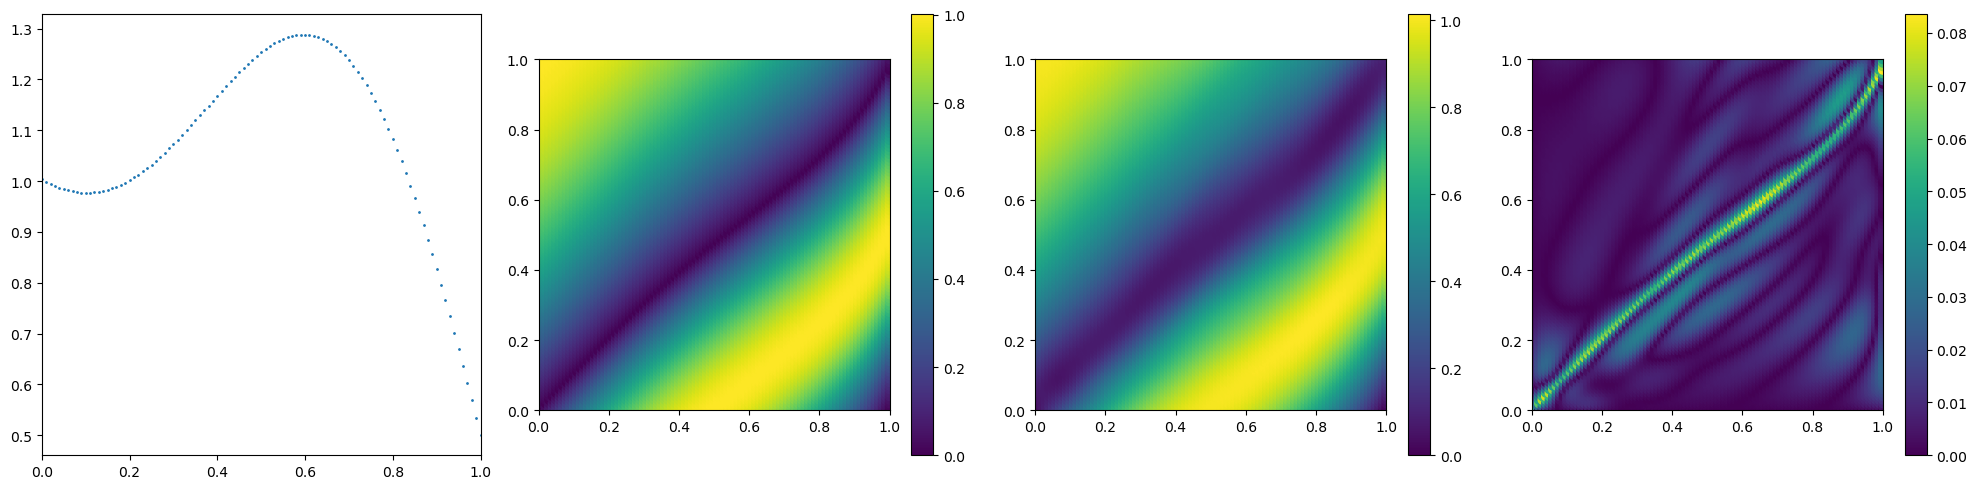

In [7]:
i = 0
# plot-data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,5))

v = train_vxs[i]
x = np.linspace(0,1,v.shape[0])

ax1.set_xlim(0,1)
ax1.scatter(x, v, s=1)

ut = train_uxts[i]
xt = train_grid

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_aspect('equal')
ax2.scatter(xt[...,0], xt[...,1], c=ut)
colorbar = fig.colorbar(ax2.scatter(xt[...,0], xt[...,1], c=ut), ax=ax2)

out = model.predict((train_vxs[(i,),...], xt))

ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_aspect('equal')
ax3.scatter(xt[...,0], xt[...,1], c=out)
colorbar = fig.colorbar(ax3.scatter(xt[...,0], xt[...,1], c=out), ax=ax3)

ax4.set_xlim(0,1)
ax4.set_ylim(0,1)
ax4.set_aspect('equal')
ax4.scatter(xt[...,0], xt[...,1], c=ut-out)
colorbar = fig.colorbar(ax4.scatter(xt[...,0], xt[...,1], c=np.abs(ut-out)), ax=ax4)

plt.tight_layout()
plt.show()

In [ ]:
xt[0], ut[0]

(array([0., 0.], dtype=float32), 0.0)

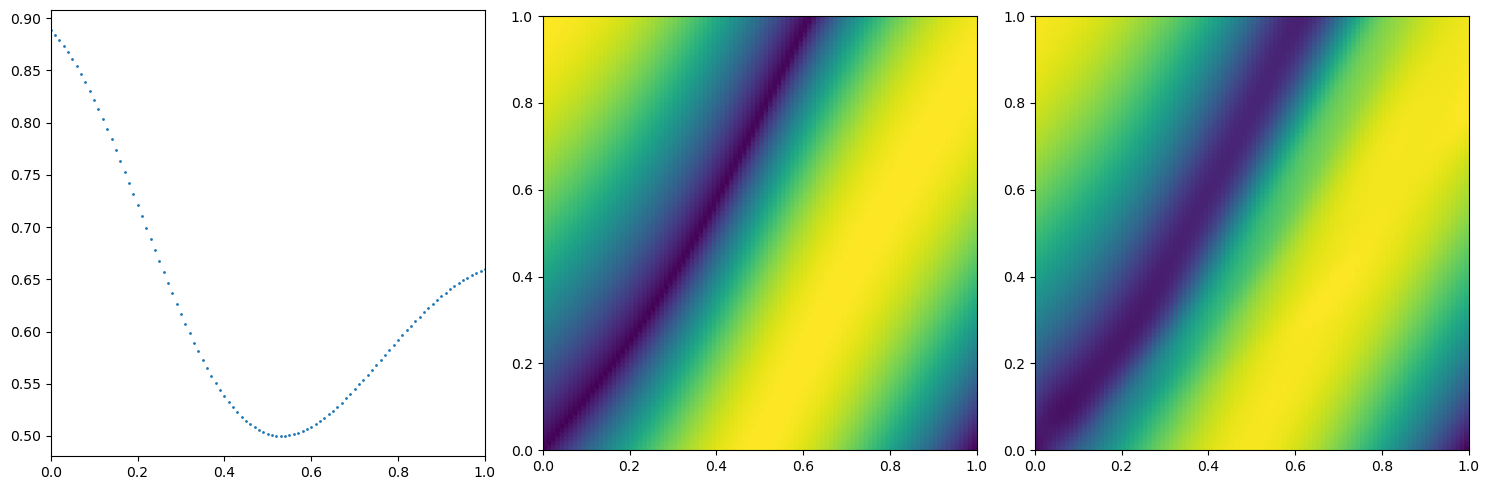

In [8]:
# plot-data
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5))

v = test_vxs[3]
x = np.linspace(0,1,v.shape[0])

ax1.set_xlim(0,1)
ax1.scatter(x, v, s=1)

ut = test_uxts[3]
xt = test_grid

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_aspect('equal')
ax2.scatter(xt[...,0], xt[...,1], c=ut)

out = model.predict((test_vxs[(3,),...], xt))

ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_aspect('equal')
ax3.scatter(xt[...,0], xt[...,1], c=out)

plt.tight_layout()
plt.show()

(100, 1000)
2.868516 0.5201367
120
Compiling model...
'compile' took 0.000269 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.17e-03]    [1.55e-03]    [4.92e-02]    
1000      [3.95e-04]    [9.51e-04]    [4.28e-02]    
2000      [4.07e-04]    [8.96e-04]    [4.27e-02]    
3000      [3.45e-04]    [7.82e-04]    [3.82e-02]    
4000      [3.75e-04]    [8.90e-04]    [4.10e-02]    
5000      [3.01e-04]    [7.82e-04]    [3.82e-02]    
6000      [2.63e-04]    [7.79e-04]    [3.79e-02]    
7000      [2.44e-04]    [7.79e-04]    [3.79e-02]    
8000      [2.63e-04]    [7.79e-04]    [3.77e-02]    
9000      [2.37e-04]    [7.87e-04]    [3.79e-02]    
10000     [2.28e-04]    [7.82e-04]    [3.78e-02]    

Best model at step 10000:
  train loss: 2.28e-04
  test loss: 7.82e-04
  test metric: [3.78e-02]

'train' took 90.282979 s



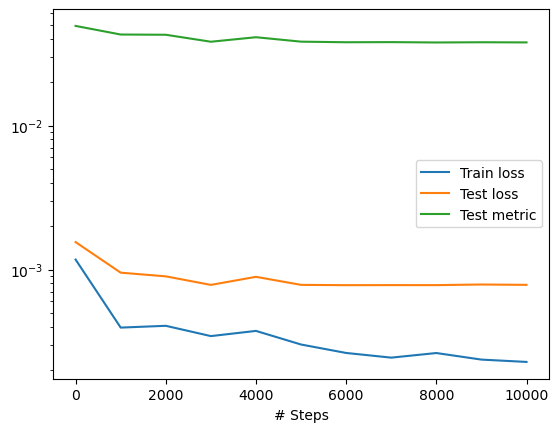

(100, 1000)
2.888823 0.53582877
140
Compiling model...
'compile' took 0.000209 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.13e-03]    [7.82e-04]    [3.78e-02]    
1000      [6.09e-04]    [9.19e-04]    [4.42e-02]    
2000      [5.42e-04]    [8.36e-04]    [4.27e-02]    
3000      [4.73e-04]    [5.80e-04]    [3.44e-02]    
4000      [4.32e-04]    [6.19e-04]    [3.54e-02]    
5000      [3.45e-04]    [6.35e-04]    [3.62e-02]    
6000      [2.84e-04]    [5.88e-04]    [3.43e-02]    
7000      [3.17e-04]    [5.84e-04]    [3.43e-02]    
8000      [3.02e-04]    [5.81e-04]    [3.39e-02]    
9000      [2.38e-04]    [5.88e-04]    [3.40e-02]    
10000     [4.00e-04]    [5.85e-04]    [3.39e-02]    

Best model at step 9000:
  train loss: 2.38e-04
  test loss: 5.88e-04
  test metric: [3.40e-02]

'train' took 93.698044 s



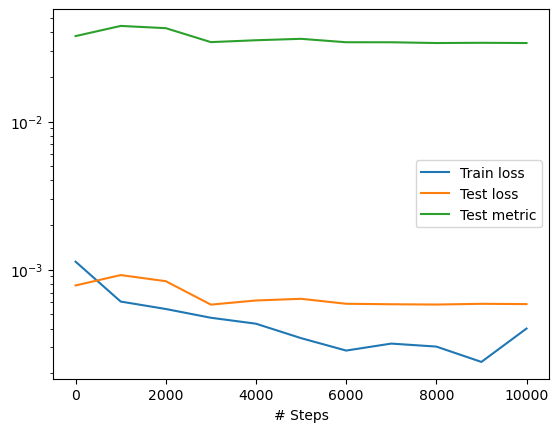

(100, 1000)
2.9060638 0.47487232
160
Compiling model...
'compile' took 0.000260 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.55e-04]    [5.85e-04]    [3.39e-02]    
1000      [4.52e-04]    [6.60e-04]    [3.71e-02]    
2000      [4.43e-04]    [6.63e-04]    [3.84e-02]    
3000      [3.86e-04]    [5.13e-04]    [3.25e-02]    
4000      [2.76e-04]    [5.27e-04]    [3.32e-02]    
5000      [3.65e-04]    [5.10e-04]    [3.25e-02]    
6000      [2.53e-04]    [5.07e-04]    [3.22e-02]    
7000      [2.43e-04]    [5.30e-04]    [3.31e-02]    
8000      [3.52e-04]    [5.09e-04]    [3.21e-02]    
9000      [2.54e-04]    [5.09e-04]    [3.20e-02]    
10000     [2.65e-04]    [5.07e-04]    [3.20e-02]    

Best model at step 7000:
  train loss: 2.43e-04
  test loss: 5.30e-04
  test metric: [3.31e-02]

'train' took 91.549709 s



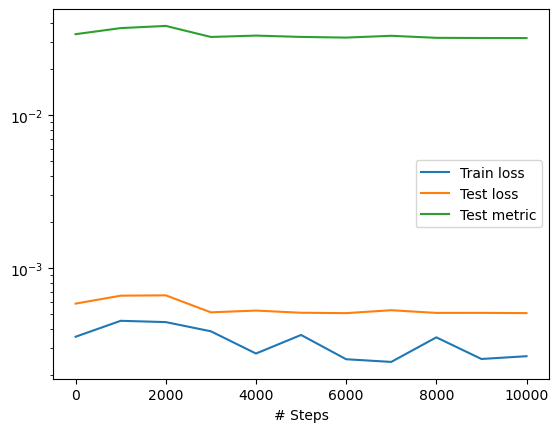

(100, 1000)
2.9685254 0.43560037
180
Compiling model...
'compile' took 0.000193 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.66e-04]    [5.07e-04]    [3.20e-02]    
1000      [4.05e-04]    [5.55e-04]    [3.41e-02]    
2000      [3.27e-04]    [5.86e-04]    [3.58e-02]    
3000      [3.04e-04]    [4.73e-04]    [3.11e-02]    
4000      [2.65e-04]    [4.84e-04]    [3.14e-02]    
5000      [3.25e-04]    [4.97e-04]    [3.21e-02]    
6000      [2.61e-04]    [4.80e-04]    [3.11e-02]    
7000      [3.18e-04]    [4.86e-04]    [3.13e-02]    
8000      [2.38e-04]    [4.77e-04]    [3.08e-02]    
9000      [2.91e-04]    [4.80e-04]    [3.09e-02]    
10000     [2.68e-04]    [4.82e-04]    [3.09e-02]    

Best model at step 8000:
  train loss: 2.38e-04
  test loss: 4.77e-04
  test metric: [3.08e-02]

'train' took 93.452719 s



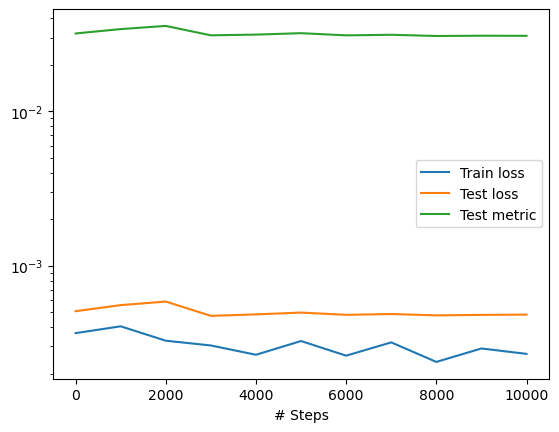

(100, 1000)
2.9161863 0.47483215
200
Compiling model...
'compile' took 0.000202 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.94e-04]    [4.82e-04]    [3.09e-02]    
1000      [3.66e-04]    [5.48e-04]    [3.39e-02]    
2000      [4.72e-04]    [6.65e-04]    [3.77e-02]    
3000      [2.19e-04]    [4.60e-04]    [3.04e-02]    
4000      [2.84e-04]    [4.80e-04]    [3.12e-02]    
5000      [2.49e-04]    [4.93e-04]    [3.16e-02]    
6000      [2.82e-04]    [4.71e-04]    [3.04e-02]    
7000      [2.31e-04]    [4.79e-04]    [3.05e-02]    
8000      [2.50e-04]    [4.75e-04]    [3.03e-02]    
9000      [2.22e-04]    [4.81e-04]    [3.04e-02]    
10000     [2.06e-04]    [4.80e-04]    [3.03e-02]    

Best model at step 10000:
  train loss: 2.06e-04
  test loss: 4.80e-04
  test metric: [3.03e-02]

'train' took 100.200374 s



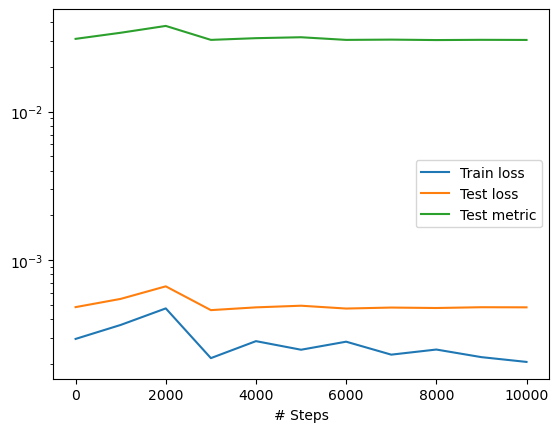

(100, 1000)
2.903679 0.4319965
220
Compiling model...
'compile' took 0.000217 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.53e-04]    [4.80e-04]    [3.03e-02]    
1000      [3.06e-04]    [5.16e-04]    [3.24e-02]    
2000      [3.31e-04]    [5.26e-04]    [3.27e-02]    
3000      [2.35e-04]    [4.69e-04]    [3.03e-02]    
4000      [2.94e-04]    [5.39e-04]    [3.36e-02]    
5000      [2.30e-04]    [4.79e-04]    [3.04e-02]    
6000      [2.59e-04]    [4.74e-04]    [3.03e-02]    
7000      [2.17e-04]    [4.71e-04]    [3.01e-02]    
8000      [2.23e-04]    [4.71e-04]    [3.00e-02]    
9000      [2.34e-04]    [4.73e-04]    [3.01e-02]    
10000     [1.96e-04]    [4.72e-04]    [3.00e-02]    

Best model at step 10000:
  train loss: 1.96e-04
  test loss: 4.72e-04
  test metric: [3.00e-02]

'train' took 93.328717 s



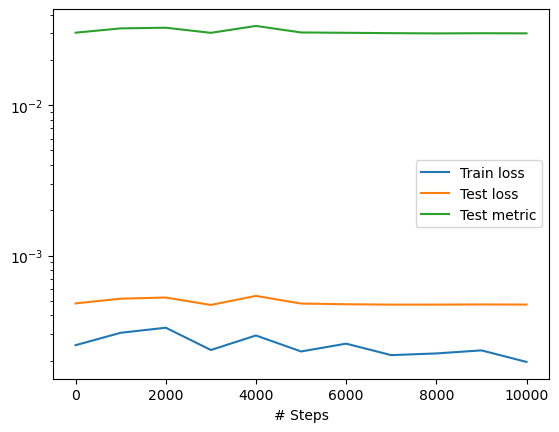

(100, 1000)
2.8759482 0.5237502
240
Compiling model...
'compile' took 0.000197 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.39e-04]    [4.72e-04]    [3.00e-02]    
1000      [2.32e-04]    [4.82e-04]    [3.10e-02]    
2000      [2.63e-04]    [4.71e-04]    [3.08e-02]    
3000      [2.06e-04]    [4.41e-04]    [2.95e-02]    
4000      [2.11e-04]    [4.53e-04]    [3.00e-02]    
5000      [1.86e-04]    [4.55e-04]    [3.00e-02]    
6000      [1.74e-04]    [4.51e-04]    [2.96e-02]    
7000      [1.91e-04]    [4.49e-04]    [2.95e-02]    
8000      [2.03e-04]    [4.47e-04]    [2.93e-02]    
9000      [1.70e-04]    [4.50e-04]    [2.94e-02]    
10000     [2.13e-04]    [4.52e-04]    [2.94e-02]    

Best model at step 9000:
  train loss: 1.70e-04
  test loss: 4.50e-04
  test metric: [2.94e-02]

'train' took 91.731997 s



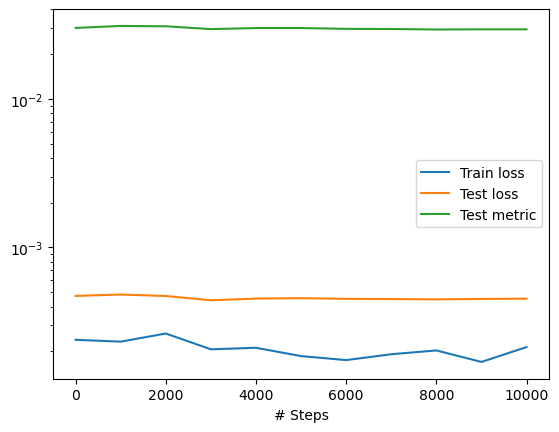

(100, 1000)
2.842279 0.45562235
260
Compiling model...
'compile' took 0.000191 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.03e-04]    [4.52e-04]    [2.94e-02]    
1000      [2.06e-04]    [4.47e-04]    [2.98e-02]    
2000      [2.69e-04]    [5.28e-04]    [3.29e-02]    
3000      [1.61e-04]    [4.30e-04]    [2.89e-02]    
4000      [2.13e-04]    [4.46e-04]    [2.97e-02]    
5000      [1.66e-04]    [4.39e-04]    [2.91e-02]    
6000      [1.98e-04]    [4.32e-04]    [2.87e-02]    
7000      [1.61e-04]    [4.36e-04]    [2.89e-02]    
8000      [1.99e-04]    [4.37e-04]    [2.87e-02]    
9000      [1.55e-04]    [4.36e-04]    [2.86e-02]    
10000     [1.55e-04]    [4.37e-04]    [2.86e-02]    

Best model at step 10000:
  train loss: 1.55e-04
  test loss: 4.37e-04
  test metric: [2.86e-02]

'train' took 91.781735 s



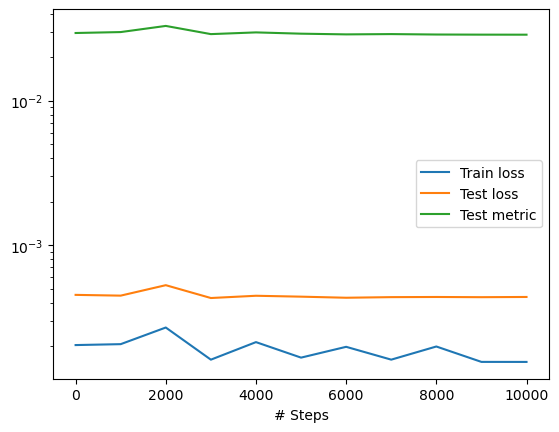

(100, 1000)
2.9765155 0.44744018
280
Compiling model...
'compile' took 0.000170 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.56e-04]    [4.37e-04]    [2.86e-02]    
1000      [2.19e-04]    [5.73e-04]    [3.44e-02]    
2000      [2.71e-04]    [5.27e-04]    [3.31e-02]    
3000      [1.81e-04]    [4.21e-04]    [2.82e-02]    
4000      [1.93e-04]    [4.33e-04]    [2.90e-02]    
5000      [1.59e-04]    [4.25e-04]    [2.83e-02]    
6000      [1.76e-04]    [4.29e-04]    [2.82e-02]    
7000      [1.77e-04]    [4.33e-04]    [2.83e-02]    
8000      [1.66e-04]    [4.30e-04]    [2.81e-02]    
9000      [1.61e-04]    [4.34e-04]    [2.81e-02]    
10000     [1.56e-04]    [4.37e-04]    [2.81e-02]    

Best model at step 10000:
  train loss: 1.56e-04
  test loss: 4.37e-04
  test metric: [2.81e-02]

'train' took 89.650019 s



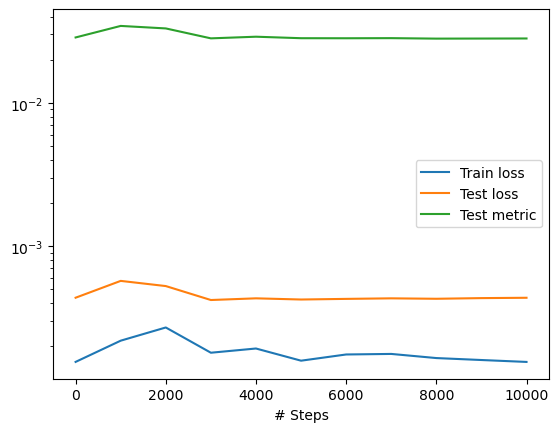

(100, 1000)
2.907788 0.4674955
300
Compiling model...
'compile' took 0.000168 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.30e-04]    [4.37e-04]    [2.81e-02]    
1000      [1.92e-04]    [4.09e-04]    [2.89e-02]    
2000      [2.19e-04]    [3.96e-04]    [2.84e-02]    
3000      [1.92e-04]    [4.03e-04]    [2.83e-02]    
4000      [1.76e-04]    [3.80e-04]    [2.77e-02]    
5000      [1.61e-04]    [3.89e-04]    [2.82e-02]    
6000      [2.07e-04]    [4.10e-04]    [2.92e-02]    
7000      [1.51e-04]    [3.64e-04]    [2.71e-02]    
8000      [1.81e-04]    [3.76e-04]    [2.76e-02]    
9000      [2.22e-04]    [3.76e-04]    [2.76e-02]    
10000     [1.90e-04]    [3.65e-04]    [2.72e-02]    
11000     [1.48e-04]    [3.51e-04]    [2.63e-02]    
12000     [1.55e-04]    [3.70e-04]    [2.73e-02]    
13000     [1.63e-04]    [3.43e-04]    [2.60e-02]    
14000     [1.45e-04]    [3.55e-04]    [2.65e-02]    
15000     [1.52e-04]    [3.51e-04]    [2.64e-02]    

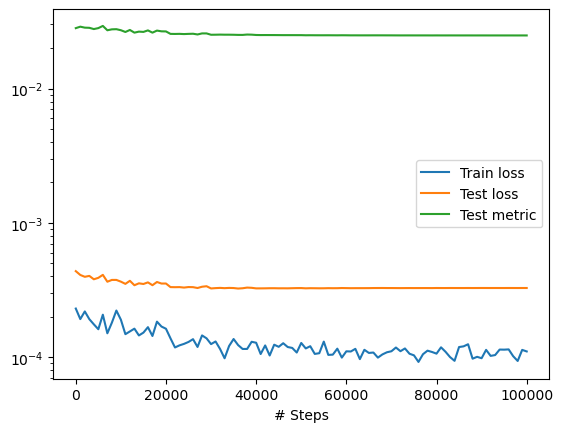

In [ ]:
# tune
while len(train_vxs) < total_training_vx:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, advection_equation, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = GRF_pos(1.0, length_scale = ls, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, check_num, [0])
    # testing_model = dde.Model(testing_new_data, net)
    (vxs, xts), _, c = testing_new_data.train_next_batch()
    out = model.predict((vxs, xts), aux_vars = c, operator = advection_equation)
    
    res = np.mean(np.abs(out), axis = 1)
    print(np.mean(res), np.std(res))
    select_num = min(select_num, total_training_vx - len(train_vxs))
    topk_index = np.argpartition(res, -select_num)[-select_num:] # select the top 20 vxs
    # print(res, topk_index, res[topk_index])
    topk_vxs = vxs[topk_index]
    xt, uxts = advection_solver(topk_vxs)
    uxts = uxts.reshape(-1, 101 * 101)
 
    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])
    
    # tune-train
    model = dde.Model(data, net)
    lr = lr_middle if len(train_vxs) != total_training_vx else lr_end
    decay = decay_middle if len(train_vxs) != total_training_vx else decay_end
    batchsize = batch_middle(len(train_vxs)) if len(train_vxs) != total_training_vx else batch_end(len(train_vxs))
    iterations = iter_middle if len(train_vxs) != total_training_vx else iter_end
    model.compile("adam", 
                  lr = lr, 
                  metrics = ["mean l2 relative error"],
                  decay = decay,)

    losshistory, train_state = model.train(iterations=iterations, batch_size = batchsize)
    
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/adv_{date}_rasg.csv"), pd_frame], axis = 0, ignore_index=True)
    pd_frame.to_csv(f"results/adv_{date}_rasg.csv", index=False)
    dde.utils.plot_loss_history(losshistory)
    plt.show()
    
torch.save(model.state_dict(), f"results/adv_model_{date}_rasg.pth")